<a href="https://colab.research.google.com/github/CharlesYSH/DQN_freeway/blob/master/DQN_Freeway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep Q larning (DQN)**

In [0]:
# check device driver
!nvidia-smi

In [0]:
import os
import gym
import math
import random
import argparse
import numpy as np
from collections import namedtuple

import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use device: %s"%device)

In [0]:
parser = argparse.ArgumentParser()
parser.add_argument("--train_ep", default=800, type=int)
parser.add_argument("--mem_capacity", default=90000, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--lr", default=0.00025, type=float)
parser.add_argument("--gamma", default=0.999, type=float)
parser.add_argument("--epsilon_start", default=1.0, type=float)
parser.add_argument("--epsilon_final", default=0.1, type=float)
parser.add_argument("--epsilon_decay", default=1000000, type=float)
parser.add_argument("--target_step", default=10000, type=int)
parser.add_argument("--eval_per_ep", default=10, type=int)
parser.add_argument("--save_per_ep", default=50, type=int)
parser.add_argument("--save_dir", default="./model")
parser.add_argument("--log_file", default="./log.txt")
parser.add_argument("--load_model", default=None)

Memory buffer for experience replay

In [0]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Convolutional Neural Network

In [0]:
class CNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        def conv2d_size_out(size, kernel_size = 3, stride = 1):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        
        self.fc = nn.Linear(linear_input_size, 512)
        self.head = nn.Linear(512, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)

DQN agent

In [0]:
class DQN(object):
    def __init__(self):
        self.BATCH_SIZE = args.batch_size
        self.GAMMA = args.gamma
        self.EPS_START = args.epsilon_start
        self.EPS_END = args.epsilon_final
        self.EPS_DECAY = args.epsilon_decay
        self.LEARN_RATE = args.lr

        self.action_dim = 3
        self.state_dim = (84,84)
        self.epsilon = 0.0
        self.update_count = 0
        
        self.policy_net = CNN(84, 84, self.action_dim).to(device)
        self.target_net = CNN(84, 84, self.action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.RMSprop(self.policy_net.parameters(), lr=self.LEARN_RATE)
        
        self.memory = ReplayMemory(args.mem_capacity)
        self.interaction_steps = 0

    def select_action(self, state):
        self.interaction_steps += 1
        self.epsilon = self.EPS_END + np.maximum( (self.EPS_START-self.EPS_END) * (1 - self.interaction_steps/self.EPS_DECAY), 0)
        if random.random() < self.epsilon:
            return torch.tensor([[random.randrange(self.action_dim)]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)

    def evaluate_action(self, state, rand=0.1):
        if random.random() < rand:
            return torch.tensor([[random.randrange(self.action_dim)]], device=device, dtype=torch.long)
        with torch.no_grad():
            return self.target_net(state).max(1)[1].view(1, 1)


    def store(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)

    def update(self):
        if len(self.memory) < self.BATCH_SIZE:
            print("[Warning] Memory data less than batch sizes!")
            return
        
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        final_mask = torch.cat(batch.done)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(self.BATCH_SIZE,1, device=device)
        next_state_values[final_mask.bitwise_not()] = self.target_net(non_final_next_states).max(1, True)[0].detach()

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
    
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % args.target_step == 0:
            self.update_target_net()

        
    def update_target_net(self):
        with torch.no_grad():
            self.target_net.load_state_dict(self.policy_net.state_dict())
            # Partially update weight
            #for q, q_targ in zip(self.policy_net.parameters(), self.target_net.parameters()):
            #    q_targ.data.mul_(0.05)
            #    q_targ.data.add_(0.95 * q.data)
            #self.target_net.eval()

    def save_model(self, path="."):
        torch.save(self.target_net.state_dict(), path+'/q_target_checkpoint_{}.pth'.format(self.interaction_steps))
        torch.save(self.policy_net.state_dict(), path+'/q_policy_checkpoint_{}.pth'.format(self.interaction_steps))

    def restore_model(self, path):
        self.target_net.load_state_dict(torch.load(path, map_location=device))
        self.policy_net.load_state_dict(torch.load(path, map_location=device))
        self.target_net.eval()
        print("[Info] Restore model from '%s' !"%path)

Uniform random agent

In [0]:
class RandomAgent(object):
    def __init__(self):
        self.action_dim = 3
        self.interaction_steps = 0

    def select_action(self, state):
        self.interaction_steps += 1
        return torch.tensor( [random.sample([0,1,2],1)], device=device, dtype=torch.long )

    def evaluate_action(self, state):
        return torch.tensor( [random.sample([0,1,2],1)], device=device, dtype=torch.long )


Markov state for Gym environment <br>
https://gym.openai.com/envs/Freeway-v0/

"Freeway-v0", "Freeway-v4", <br>
"FreewayDeterministic-v0", "FreewayDeterministic-v4", <br>
"FreewayNoFrameskip-v0", "FreewayNoFrameskip-v4"

In [0]:
frame_proc = T.Compose([T.ToPILImage(),
                        T.Grayscale(), \
                        T.Resize((84,84), interpolation=Image.BILINEAR), \
                        T.ToTensor()])

class Atari(object):
    def __init__(self, env_name="FreewayDeterministic-v4", agent_history_length=4):
        self.env = gym.make(env_name)
        self.state = None
        self.agent_history_length = agent_history_length

    def reset(self):
        observation = self.env.reset()
        frame = self.image_proc(observation).to(device)
        self.state = frame.repeat(1,self.agent_history_length,1,1)
        return self.state

    def image_proc(self, image):
        return frame_proc(image)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        frame = self.image_proc(observation).to(device)
        next_state = torch.cat( (self.state[:, 1:, :, :], frame.unsqueeze(0)), axis=1 )
        self.state = next_state
        return next_state, reward, done, info

    def get_render(self):
        observation = self.env.render(mode='rgb_array')
        return observation

    def render(self):
        self.env.render()

In [0]:
def train():
    num_episodes = args.train_ep
    save_model_per_ep = args.save_per_ep
    log_fd = open(args.log_file,'w')

    agent = DQN()
    env = Atari()

    if args.load_model:
      agent.restore_model(args.load_model)
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    
    global_steps = 0
    for i_episode in range(num_episodes):
        episode_reward = 0
        state = env.reset()

        for _ in range(10000):
            #env.render()
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            
            if done:
                next_state = None

            agent.memory.push(  state, \
                                action, \
                                next_state, \
                                torch.tensor([[reward]], device=device), \
                                torch.tensor([done], device=device, dtype=torch.bool))
            state = next_state
            episode_reward += reward
            global_steps += 1 

            if global_steps > 50000:
                agent.update()

            if done:
                train_info_str = "Episode: %6d, interaction_steps: %6d, reward: %2d, epsilon: %f"%(i_episode, agent.interaction_steps, episode_reward, agent.epsilon)
                print(train_info_str)
                log_fd.write(train_info_str)
                break

        if i_episode % save_model_per_ep == 0:
            agent.save_model(args.save_dir)
            print("[Info] Save model at '%s' !"%args.save_dir)

        if i_episode % args.eval_per_ep == 0:
            test_env = Atari()
            average_reward = 0
            test_ep = 5

            for t_ep in range(test_ep):
                state = test_env.reset()
                episode_reward = 0
                for _ in range(10000):
                    action = agent.evaluate_action(state)
                    state, reward, done, _ = test_env.step(action.item())
                    episode_reward += reward
                average_reward += episode_reward
            average_reward /= test_ep
            
            eval_info_str = "Evaluation: True, Episode: %6d, Interaction_steps: %6d, evaluate reward: %f"%(i_episode, agent.interaction_steps, average_reward)
            print(eval_info_str)
            log_fd.write(eval_info_str)
    
    log_fd.close()

In [0]:
args = parser.parse_args(args=[]) #For jupyter notebook

if not os.path.isfile(args.save_dir):
    os.makedirs( args.save_dir )
    print("[Info] make directory '%s'"%args.save_dir)
    
train()

In [0]:
def test(path):
    #agent = RandomAgent()
    agent = DQN()
    env = Atari()
    
    agent.restore_model(path)

    for i_episode in range(10):
        episode_reward = 0
        state = env.reset()

        for _ in range(10000):
            #env.render()
            action = agent.evaluate_action(state)
            next_state, reward, done, _ = env.step(action.item())
            state = next_state
            episode_reward += reward

            if done:
                print("Episode: %6d, interaction_steps: %6d, reward: %2d, epsilon: %f"%(i_episode, agent.interaction_steps, episode_reward, 0.1))
                break

In [0]:
args = parser.parse_args(args=[]) #For jupyter notebook

model_path = "./model/q_target_checkpoint_1947648.pth"
test(model_path)

Episode:      0, interaction_steps:      0, reward: 31, epsilon: 0.100000


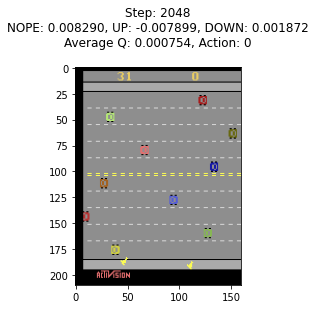

In [11]:
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

class LearntAgent(object):
    def __init__(self):
        self.action_dim = 3
        self.net = CNN(84, 84, self.action_dim).to(device)
        self.interaction_steps = 0

    def evaluate_action(self, state, rand=0.1):
        if random.random() < rand:
            return torch.tensor([[random.randrange(self.action_dim)]], device=device, dtype=torch.long), np.array([[0., 0., 0.,]])
        with torch.no_grad():
            q_value = self.net(state)
            return q_value.max(1)[1].view(1, 1), q_value.cpu().numpy()

    def restore_model(self, path):
        self.net.load_state_dict(torch.load(path, map_location=device))
        self.net.eval()
        print("[Info] Restore model from '%s' !"%path)


def play(path):
    agent = LearntAgent()
    env = Atari()
    
    agent.restore_model(path)

    for i_episode in range(1):
        episode_reward = 0
        state = env.reset()

        fig = plt.figure()
        fig.set_facecolor('w')
        img0 = plt.imshow(env.get_render())
        
        for s in range(10000):
            #env.render()
            action, q_value = agent.evaluate_action(state)

            plt.title( "Step: %04d\nNOPE: %f, UP: %f, DOWN: %f\nAverage Q: %f, Action: %d\n"\
                        %(s+1, q_value[0,0], q_value[0,1], q_value[0,2], np.average(q_value), action.item()) )
            img0.set_data(env.get_render())
            display.display(plt.gcf())
            display.clear_output(wait=True)

            next_state, reward, done, _ = env.step(action.item())
            state = next_state
            episode_reward += reward

            if done:
                print("Episode: %6d, interaction_steps: %6d, reward: %2d, epsilon: %f"%(i_episode, agent.interaction_steps, episode_reward, 0.1))
                break

model_path = "./model/q_target_checkpoint_1947648.pth"
play(model_path)